Evaluate the best model, which is found seperatly using Weights and Biases (which MACE supports)

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import subprocess
from ase.io import read
from fff.fff_mace_utils.fffmaceutils import h5_to_xyz
from shutil import rmtree
from pathlib import Path

Give the name of the best model and create a directory for any saved data

In [18]:
models = ["mace_run-21940057_initial", "mace_run-27650412_initial", "mace_run-10739442_initial"]
outputs_dir = Path("data")
if not Path(outputs_dir).exists():
    outputs_dir.mkdir()

Create an evaluate.xyz set for evaluating the MACE model's performance

In [19]:
if not Path(f"{outputs_dir}/evaluate.xyz").exists():
    h5_to_xyz("../data/raw-data/ani1x-release.h5", f"{outputs_dir}/evaluate.xyz", percentage=0.04) #Makes the evaluate dataset from a percentage of the real one

Create a command to run the eval_configs.py script from MACE as a subprocess

In [20]:
commands = {}
for model in models:
    if not Path(f"{outputs_dir}/{model}.xyz").exists():
        commands[model] = [
            "python",
            "../../../mace/scripts/eval_configs.py",
            "--model", f"../runs/checkpoints/{model}.model",
            "--device", "cuda",
            "--output", f"{outputs_dir}/{model}.xyz",
            "--configs", f"{outputs_dir}/evaluate.xyz"
        ]

In [21]:
for command in commands.values():
    subprocess.run(command)

Read and parse the predicted and real data from the MACE model

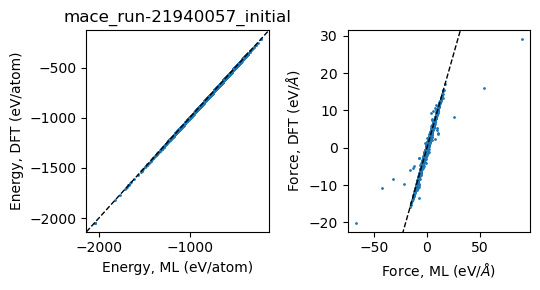

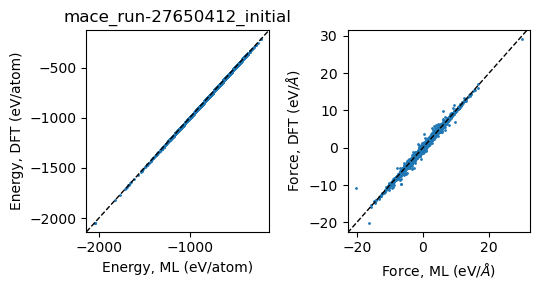

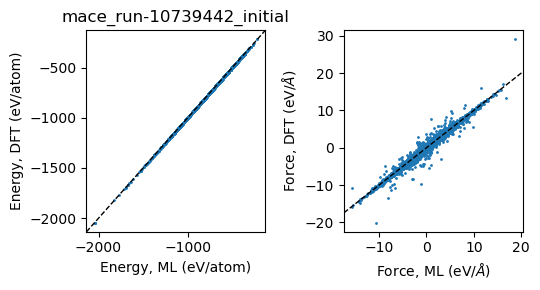

In [22]:
for name in models:
    data = read(f"{outputs_dir}/{name}.xyz", index=":")
    ml_energy = [molecule.info["MACE_energy"] for molecule in data]
    ml_forces = np.concatenate([molecule.arrays["MACE_forces"].ravel() for molecule in data])
    true_forces = np.concatenate([molecule.arrays["forces"].ravel() for molecule in data])
    true_energy = [molecule.info["energy"] for molecule in data]
    ml_energy_per_atom = np.array(ml_energy) / np.array([len(molecule) for molecule in data])
    true_energy_per_atom = np.array(true_energy) / np.array([len(molecule) for molecule in data])

    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(5.5, 3.))

    # Energy plot
    axs[0].scatter(ml_energy_per_atom, true_energy_per_atom, s=1)
    axs[0].set_xlabel('Energy, ML (eV/atom)')
    axs[0].set_ylabel('Energy, DFT (eV/atom)')
    axs[0].set_title(name)

    # Force plot
    axs[1].scatter(ml_forces, true_forces, s=1)
    axs[1].set_xlabel('Force, ML (eV/$\\AA$)')
    axs[1].set_ylabel('Force, DFT (eV/$\\AA$)')

    for ax in axs:
        ax.set_xlim(ax.get_xlim())
        ax.set_ylim(ax.get_ylim())
        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

    fig.tight_layout()
    plt.show()